In [1]:
import os
import random
import warnings

import matplotlib.pyplot as plt
import simplstyles
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend

from residual import residual_method
from dataset import generate_dataset
from variance_partitioning import variance_partitioning

In [2]:
def get_path(alphas, cv, n_targets):
    path = os.path.join("results", f"targets={n_targets}", f"cv={cv}",
                        f"alphas={alphas.min()},{alphas.max()},{len(alphas)}", "varying training samples")
    os.makedirs(path, exist_ok=True)
    return path

In [3]:
def save_scores(samples_train, d_list, scalars, n_targets, n_samples_test, noise_target, cv, alphas):
    path = get_path(alphas, cv, n_targets)
    for n_samples_train in samples_train:
        print(n_samples_train)
        csv_path = os.path.join(path, f"scores_{n_samples_train}.csv")
        scores = pd.DataFrame()
        if os.path.exists(csv_path):
            print("skipping, already exists")
            continue
        Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples_train + n_samples_test, noise_target)
        print("data generated")
        x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score = variance_partitioning(
            Xs, Y, n_samples_train, alphas, cv)
        print("variance partitioning done")

        scores["x1_score"] = x1_score
        scores["x2_score"] = x2_score
        scores["vp_joint_score"] = joint_score
        scores["vp_shared_score"] = x1_and_x2_score
        scores["vp_x1_unique_score"] = vp_x1_unique_score
        scores["vp_x2_unique_score"] = vp_x2_unique_score
        del x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score

        x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score = residual_method(
            Xs, Y, n_samples_train, alphas, cv)
        print("residual method done")
        scores["rm_x2_to_x1_score"] = np.concatenate(
            [x2_to_x1_score, np.full(len(rm_x1_unique_score) - len(x2_to_x1_score), np.nan)])
        scores["rm_x1_to_x2_score"] = np.concatenate(
            [x1_to_x2_score, np.full(len(rm_x1_unique_score) - len(x1_to_x2_score), np.nan)])
        scores["rm_x1_unique_score"] = rm_x1_unique_score
        scores["rm_x2_unique_score"] = rm_x2_unique_score
        print(scores.head())
        del x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score

        # ridge residual
        x2_to_x1_ridge_score, x1_to_x2_ridge_score, rm_ridge_x1_unique_score, rm_ridge_x2_unique_score = residual_method(
            Xs, Y, n_samples_train, alphas, cv, use_ols=False)
        print("residual method done")
        scores["rm_ridge_x2_to_x1_score"] = np.concatenate(
            [x2_to_x1_ridge_score, np.full(len(rm_ridge_x1_unique_score) - len(x2_to_x1_ridge_score), np.nan)])
        scores["rm_ridge_x1_to_x2_score"] = np.concatenate(
            [x1_to_x2_ridge_score, np.full(len(rm_ridge_x1_unique_score) - len(x1_to_x2_ridge_score), np.nan)])
        scores["rm_ridge_x1_unique_score"] = rm_ridge_x1_unique_score
        scores["rm_ridge_x2_unique_score"] = rm_ridge_x2_unique_score
        print(scores.head())
        del x2_to_x1_ridge_score, x1_to_x2_ridge_score, rm_ridge_x1_unique_score, rm_ridge_x2_unique_score
        del Xs, Y
        scores.to_csv(csv_path, index=False)

# Save scores for varying training samples

In [4]:
backend = set_backend("cupy", on_error="warn")
warnings.filterwarnings("ignore")
random.seed(42)
plt.style.use('nord-light-talk')

In [5]:
d_list = [100, 100, 100]
n_targets = 10000
n_samples_test = 10000
scalars = [1 / 3, 1 / 3, 1 / 3]
noise_target = 0.1

cv = 10
alphas = np.logspace(-5, 5, 10)

In [6]:
import math

numsteps = 10
samples_train = np.logspace(math.log(301, 10), math.log(23000.5, 10), numsteps).astype(int)
samples_train

array([  300,   487,   788,  1277,  2067,  3347,  5420,  8775, 14206,
       23000])

In [7]:
save_scores(samples_train, d_list, scalars, n_targets, n_samples_test, noise_target, cv, alphas)

300
skipping, already exists
487
skipping, already exists
788
skipping, already exists
1277
skipping, already exists
2067
skipping, already exists
3347
skipping, already exists
5420
skipping, already exists
8775
skipping, already exists
14206
skipping, already exists
23000
skipping, already exists


# Load scores

In [8]:
vp = pd.DataFrame()
rm = pd.DataFrame()
rm_ridge = pd.DataFrame()

for i, n_samples_train in enumerate(samples_train):
    scores = pd.read_csv(os.path.join(get_path(alphas, cv, n_targets), f"scores_{n_samples_train}.csv"))
    vp_scores = pd.DataFrame({
        'n_samples_train': [n_samples_train] * len(scores),
        'vp_x1_unique_score': scores['vp_x1_unique_score'],
    }, index=range(len(scores)))

    rm_scores = pd.DataFrame({
        'n_samples_train': [n_samples_train] * len(scores),
        'rm_x1_unique_score': scores['rm_x1_unique_score'],
    }, index=range(len(scores)))

    rm_ridge_scores = pd.DataFrame({
        'n_samples_train': [n_samples_train] * len(scores),
        'rm_ridge_x1_unique_score': scores['rm_ridge_x1_unique_score'],
    }, index=range(len(scores)))

    vp = pd.concat([vp, vp_scores], ignore_index=True)
    rm = pd.concat([rm, rm_scores], ignore_index=True)
    rm_ridge = pd.concat([rm_ridge, rm_ridge_scores], ignore_index=True)
vp.head()
rm.head()

,n_samples_train,rm_x1_unique_score
0,300,0.000292
1,300,0.000274
2,300,0.000356
3,300,0.000256
4,300,0.000367


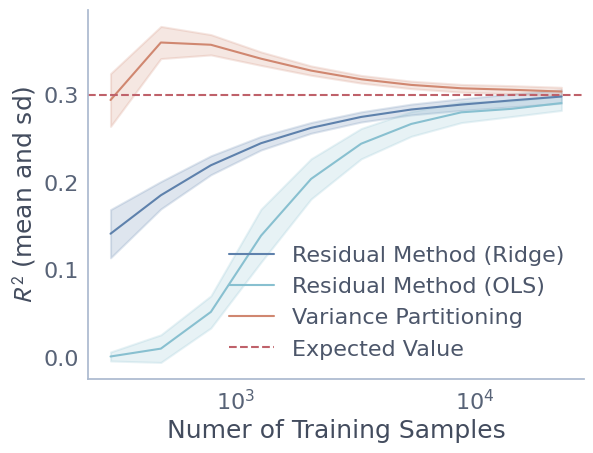

In [10]:
import matplotlib as mpl
# fig, ax = plt.subplots(1, 1, figsize=(4, 4))
hue_order = ['Residual Method', 'Variance Partitioning', ]
g = sns.lineplot(data=rm_ridge, x='n_samples_train', y='rm_ridge_x1_unique_score', label='Residual Method (Ridge)', errorbar='sd')
sns.lineplot(data=rm, x='n_samples_train', y='rm_x1_unique_score', label='Residual Method (OLS)', errorbar='sd')
sns.lineplot(data=vp, x='n_samples_train', y='vp_x1_unique_score', label='Variance Partitioning', errorbar='sd')
plt.axhline(scalars[1] * (1 - noise_target), linestyle='--', label='Expected Value', color="C3")
plt.xlabel(r"Numer of Training Samples")
plt.ylabel(r"$R^2$ (mean and sd)")
plt.legend()
# xtick_labels = [str(int(x)) for x in samples_train]
xticks = [x for x in samples_train]
# plt.xticks(xticks, xtick_labels)
# plt.gca().set_xticklabels(xtick_labels)
plt.xscale('log')